<a href="https://colab.research.google.com/github/LordMordo/pneumonia_inception/blob/master/pneumonia_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acquiring the necessary data.

In [0]:
!pip install -q kaggle

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:39<00:00, 22.8MB/s]
100% 2.29G/2.29G [00:40<00:00, 61.6MB/s]


In [8]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray/__MACOSX/._chest_xray  
  inflating: chest_xray/__MACOSX/chest_xray/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/._test  
  inflating: chest_xray/__MACOSX/chest_xray/._train  
  inflating: chest_xray/__MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/__MACOSX/chest_xray/test/._NORMAL  
  inflating: chest_xray/__MACOSX/chest_xray/test/._PNEUMONIA  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0001-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0003-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0005-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0006-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0007-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0009-0001.jpeg  
  inflating: chest_xray/__MACOSX/chest_xray/test/NORMAL/._IM-0010-0001.jpeg  
  inflating: chest_x

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [0]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/test'
test_dir = './chest_xray/val'

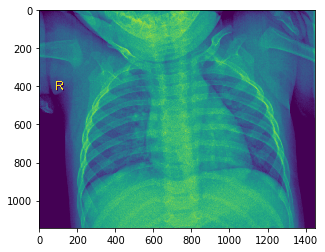

In [15]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0131-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [0]:

def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

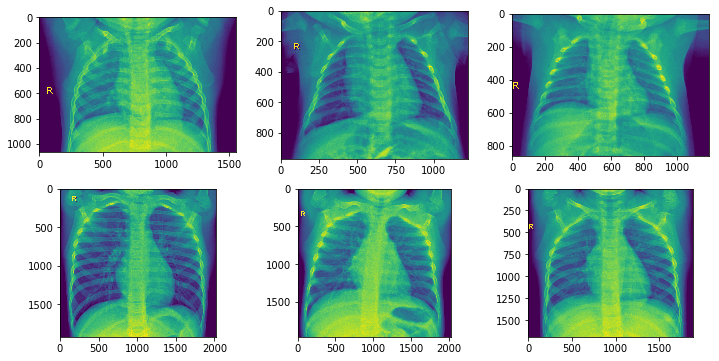

In [22]:
plot_images(training_dir + '/NORMAL')

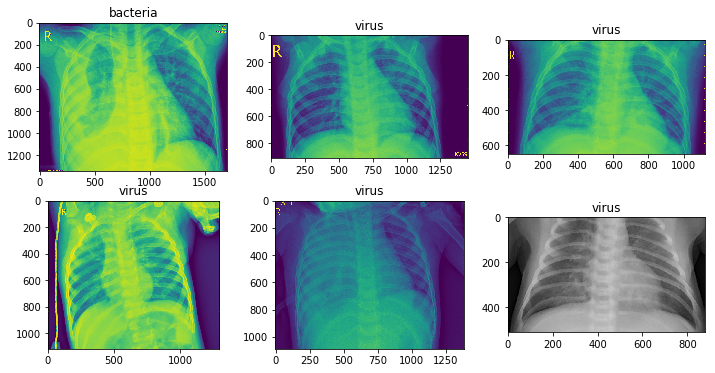

In [23]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

In [24]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [25]:
rescale = 1./255.0
target_size = (150, 150)
batch_size = 32
class_mode = 'categorical'

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)
  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.inputs, outputs=predictions)

  for layer in base_model.layers:
    layer.trainable = False
  
  model.summary()
  return model

In [27]:
model = get_model()









87916544/87910968 [==============================] - 2s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
___________________

In [29]:
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
163/163 [==============================] - 378s 2s/step - loss: 0.3948 - acc: 0.8595 - val_loss: 1.0317 - val_acc: 0.7372
Epoch 2/5
163/163 [==============================] - 369s 2s/step - loss: 0.2678 - acc: 0.8905 - val_loss: 1.4419 - val_acc: 0.6202
Epoch 3/5
163/163 [==============================] - 363s 2s/step - loss: 0.2615 - acc: 0.8949 - val_loss: 1.5844 - val_acc: 0.6715
Epoch 4/5
163/163 [==============================] - 365s 2s/step - loss: 0.2594 - acc: 0.9009 - val_loss: 1.3758 - val_acc: 0.6731
Epoch 5/5
163/163 [==============================] - 366s 2s/step - loss: 0.2238 - acc: 0.9153 - val_loss: 1.8289 - val_acc: 0.6394


In [31]:

result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

16/16 [==============================] - 1s 87ms/step
Loss: 1.4571442258136358
Accuracy: 0.6875


In [33]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_generator)):
  y_img_batch, y_true_batch = test_generator[i]
  y_true_batch = y_true_batch.argmax(axis=-1)
  y_img_batches.append(y_img_batch)
  y_true_batches.append(y_true_batch)

  y_pred_batch = model.predict(y_img_batch)
  y_pred_batch = y_pred_batch.argmax(axis=-1)
  y_pred_batches.append(y_pred_batch)

y_pred_batches

[array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0])]

In [0]:
def predict_images(images_path, label):
  amount = 0
  fig = plt.figure(figsize=(18, 8))

  for file in os.listdir(images_path):
    if file.endswith('.jpeg'):
      if amount == 8:
        break

      img = mpimg.imread(os.path.join(images_path, file))
      plt.subplot(241+amount)
      plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
      imgplot = plt.imshow(img)

      amount += 1

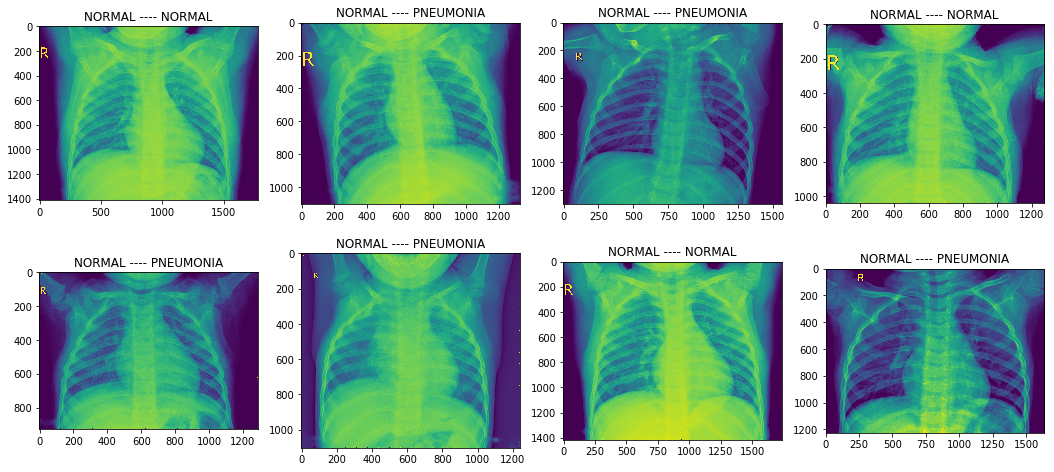

In [35]:
predict_images('./chest_xray/val/NORMAL', 'NORMAL')

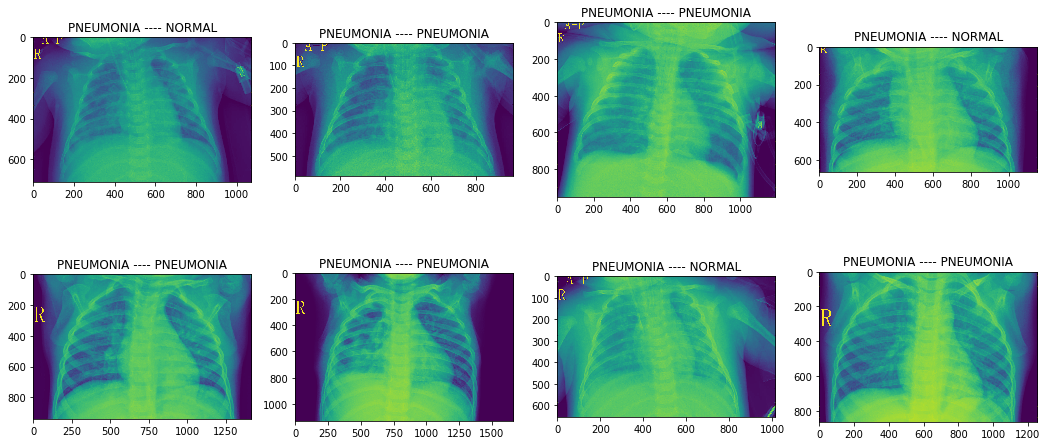

In [36]:
predict_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA')

In [0]:
model.save('pneumi_v1.h5')